In [1]:
import functools as fts
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [2]:
# load data and rename columns
df = (pd.read_csv('~/Documents/github/misc-statistics-work/daily-min-temps.csv', header=0)
      .rename(columns={'Date': 'dt', 
                       'Daily minimum temperatures': 'orig'}))

# add impd column that will contain the final imputed time series
# leaving orig as is for comparison purposes
df['impd'] = df['orig']
# indicator of imputed values
df['type'] = 0

# add 11 missing values to be imputed
# 3 are bad values in the dataset, 8 are legit values that are usable
# for evaluation purposes
for idx in [24, 179, 486, 565, 566, 755, 
            1290, 2100, 2937, 3003, 3571]:
    df.loc[idx, 'impd'] = np.nan
    df.loc[idx, 'type'] = 1

# fix data type issues
df['dt'] = pd.to_datetime(df['dt'])
df['impd'] = pd.to_numeric(df['impd'])

# view 11 rows with missing values
df[df['type'] == 1]

,dt,orig,impd,type
24,1981-01-25,16.5,NaN,1
179,1981-06-29,9.5,NaN,1
486,1982-05-02,6.3,NaN,1
565,1982-07-20,?0.2,NaN,1
566,1982-07-21,?0.8,NaN,1
755,1983-01-26,15.6,NaN,1
1290,1984-07-14,?0.1,NaN,1
2100,1986-10-03,9.9,NaN,1
2937,1989-01-18,13.9,NaN,1
3003,1989-03-25,13.2,NaN,1


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


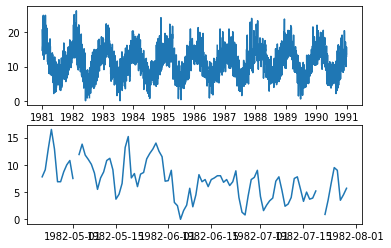

In [3]:
fig, ax = plt.subplots(2, 1)

# whole time series
ax[0].plot(df.dt, df.impd)

# 100 element segment
tmp1 = df.iloc[475:575]
ax[1].plot(tmp1.dt, tmp1.impd)

In [4]:
def do_impute(idx, d, days, wwks, weights):
    """
    Parameters
    ----------
    idx : integer
        index number of the row to be imputed
    d : pandas dataframe
        dataframe containing missing values
    days : integer
        number of days on either side of missing value to 
        consider when doing day level part of imputation
    wwks : integer
        number of weeks on either side of missing value to 
        consider when doing dow part of imputation
    weights : dictionary
        the weights used to combine all the imputation pieces together

    Returns
    -------
    float
        the imputed value
    """
    # calculate number of days in <wwks> weeks
    wdys = wwks * 7
    
    # define the dow and woy values for specific index
    tdow = d.loc[idx, 'dow']
    twoy = d.loc[idx, 'woy']

    # filtered pandas series to all dow and woy combination values
    fwoy = d.loc[(d.dow == tdow) & (d.woy == twoy), 'impd']
    # filtered pandas series to all dow values in the <wwks> closest weeks
    fdow = d.loc[(d.dow == tdow) & (d.index >= idx - wdys) & (d.index <= idx + wdys), 'impd']
    # filtered pandas series to all values within <days> days
    fday = d.loc[(d.index >= idx - days) & (d.index <= idx + days), 'impd']
    
    # return weighted sum of all the imputation components
    # the mean and median is taken of each filtered pandas series
    # 6 imputation components in total
    return round(
        (weights['woy_mean'] * fwoy.mean())
        + (weights['woy_median'] * fwoy.median())
        + (weights['dow_mean'] * fdow.mean())
        + (weights['dow_median'] * fdow.median())
        + (weights['day_mean'] * fday.mean())
        + (weights['day_median'] * fday.median()), 2
    )


def fillin_missing(d, days, wwks, weights):
    """
    Parameters
    ----------
    d : pandas dataframe
        dataframe containing missing values
    days : integer
        number of days on either side of missing value to 
        consider when doing day level part of imputation
    wwks : integer
        number of weeks on either side of missing value to 
        consider when doing dow part of imputation
    weights : dictionary
        the weights used to combine all the imputation pieces together

    Returns
    -------
    tuple
        the imputed dataframe, the needing imputation index 
        list, and the imputed values list
    """
    # add dow and woy columns
    d['dow'] = d['dt'].dt.dayofweek
    d['woy'] = d['dt'].dt.weekofyear
    
    # define list of indices needing imputation
    lidx = np.where(np.asanyarray(np.isnan(d['impd'])))[0]
    # apply do_impute to each index in list
    ival = list(map(
        fts.partial(do_impute, d=d, days=days, wwks=wwks, weights=weights), 
        lidx
    ))

    # overwrite nan values with imputed values
    d.loc[lidx, 'impd'] = ival
    
    # drop dow and woy columns
    d = d[['dt', 'orig', 'impd', 'type']]
    
    # return: 
    #     1. cleaned dataframe
    #     2. list of imputed indices
    #     3. list of imputed values
    return d, lidx, ival

In [5]:
# start time
stime = time.time()

# weights to combine imputation components
wts = {
    'woy_mean': 0.2,
    'woy_median': 0.2,
    'dow_mean': 0.2,
    'dow_median': 0.2,
    'day_mean': 0.1,
    'day_median': 0.1
}

# function execution
df_new, indices, imputed = fillin_missing(d=df, days=3, wwks=4, weights=wts)

# end time
etime = time.time()

# runtime for whole dataset in seconds
print(str(round(etime - stime, 4)) + " seconds")

0.0592 seconds


In [6]:
# view 11 rows with missing values
# some of the imputed values are great, some could use improvement
# adjust weights for potentially improved imputed values
df_new[df_new['type'] == 1]

,dt,orig,impd,type
24,1981-01-25,16.5,16.19,1
179,1981-06-29,9.5,7.76,1
486,1982-05-02,6.3,10.71,1
565,1982-07-20,?0.2,6.71,1
566,1982-07-21,?0.8,6.67,1
755,1983-01-26,15.6,15.40,1
1290,1984-07-14,?0.1,7.14,1
2100,1986-10-03,9.9,10.07,1
2937,1989-01-18,13.9,15.92,1
3003,1989-03-25,13.2,14.40,1


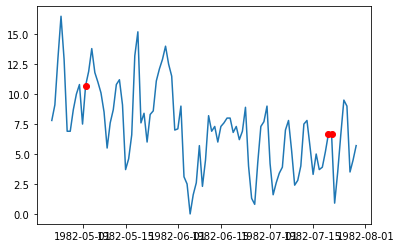

In [7]:
# 100 element segment with imputed values highlighted
tmp2 = df_new.iloc[475:575]
plt.plot(tmp2.dt, tmp2.impd)
tmp2f = tmp2[tmp2.type == 1]
plt.plot(tmp2f.dt, tmp2f.impd, 'o', c='red', ms=6)